In [53]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [54]:

cities = ['san_francisco', 'nyc_brooklyn', 'shenzhen_downtown_west', 'washington_dc']
city = cities[3]
with open(f"../data/scenario_{city}.json") as f:
    data = json.loads(f.read())

In [55]:
df = pd.DataFrame(data["demand"])

# Simple summary stats

In [56]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [57]:
df_org_dest.head()

origin destination price               demand travel_time
                     count       mean      mean        mean
0      0           1   120  13.400000  0.066667   14.000000
1      0           2   180  15.266667  0.077778   20.666667
2      0           3   180  12.166667  0.138889   14.333333
3      0           4   180   9.333333  0.688889    9.666667
4      0           5   180  12.433333  0.838889   14.666667

In [58]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [59]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,24780.000000,24780.000000,24780.000000,24780.000000,24780.000000,24780.000000
mean,1227.320823,5.992736,7.576271,0.121186,13.871671,11.722518
std,51.719791,4.017892,4.392148,0.182164,7.010372,3.827296
min,1140.000000,0.000000,0.000000,0.016667,3.000000,0.000000
25%,1183.000000,3.000000,4.000000,0.016667,9.000000,9.000000
50%,1226.000000,6.000000,7.000000,0.050000,12.000000,11.000000
75%,1271.000000,9.000000,11.000000,0.133333,17.000000,13.600000
max,1319.000000,16.000000,17.000000,0.966667,68.000000,24.900000


In [60]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16]
Destination nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


# Grid analysis

In [61]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

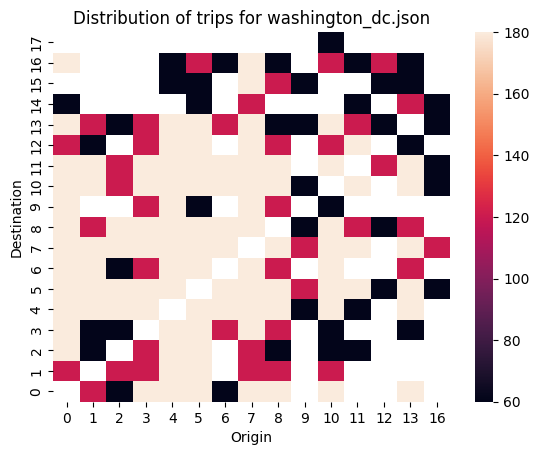

In [62]:
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d")
plt.title(f"Distribution of trips for {city}.json")
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.savefig(f"./figs/DistributionOfTrips_{city}")
plt.show()

In [63]:
# mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])
# plt.figure(figsize=(10, 8))
# sns.heatmap(mean_demand_matrix.reshape(2,5), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
# plt.title('Heatmap of Mean Demand in Each Grid')
# plt.xlabel('Longitude Grid')
# plt.ylabel('Latitude Grid')
# plt.show()

# Travel time analysis

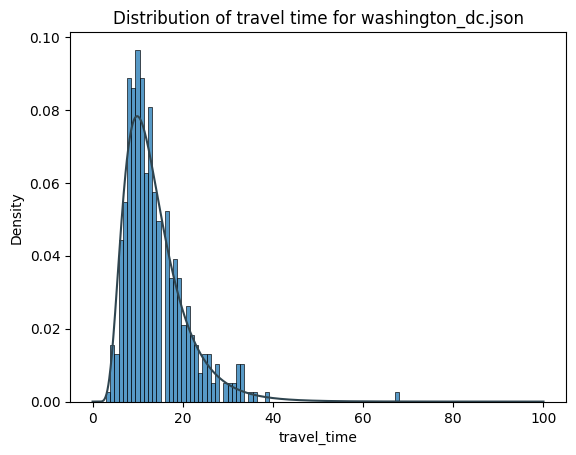

In [64]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title(f"Distribution of travel time for {city}.json")
plt.savefig(f"./figs/TravelTimeDist_{city}")
plt.show()

# Price analysis

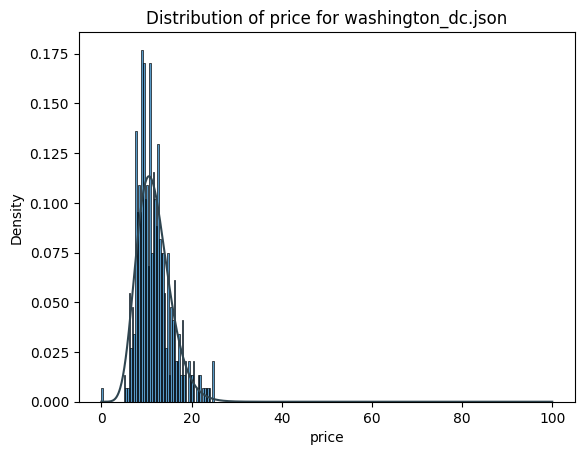

In [65]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title(f"Distribution of price for {city}.json")
plt.savefig(f"./figs/DistOfPrice_{city}")
plt.show()

In [66]:
pred_df = df.copy()

In [67]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

c:\Users\joach\AppData\Local\pypoetry\Cache\virtualenvs\multi-agent-reinforcement-learning-POZmGtHo-py3.10\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
glm_model = smf.glm(formula="price ~ travel_time + demand", data=pred_df, family=sm.families.Gaussian())

In [69]:
fitted_glm = glm_model.fit()

In [70]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24780
Model:                            GLM   Df Residuals:                    24777
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          3.2457
Method:                          IRLS   Log-Likelihood:                -49747.
Date:                Mon, 27 Nov 2023   Deviance:                       80419.
Time:                        15:46:24   Pearson chi2:                 8.04e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9702
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9518      0.027    186.285      0.000       4.900       5.004
travel_time     0.4816      0.002    294.940      0.000       0.478       0.485
demand          0.7492      0.063     11.923      0.000       0.626       0.872
===============================================================================
"""

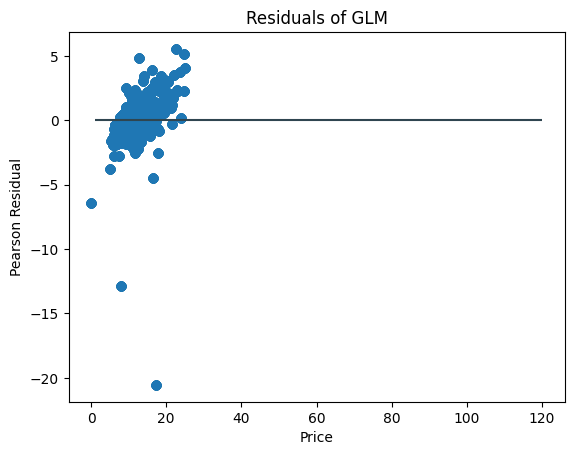

In [71]:
plt.scatter(pred_df["price"], pred_df["price"] - fitted_glm.predict())
plt.hlines(y=0, xmin=1, xmax=120, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()